# Example 1: Square with a Circular Hole

Given an open, bounded, connected region $K \subset \mathbb{R}^2$
with a sufficiently "nice" boundary, let $v,w : K \to \mathbb{R}$
be functions of the form
\begin{align*}
	v = \phi + P~,
	\quad 
	w = \psi + Q
\end{align*}
where $\phi,\psi$ are harmonic functions and $P,Q$ are polynomials.
The goal of this example is to compute the 
$H^1$ semi-inner product and $L^2$ inner product
\begin{align*}
	\int_K \nabla v \cdot \nabla w ~dx 
	~, \quad 
	\int_K v \, w ~dx
\end{align*}
using only 
(i) the Dirichlet traces $v|_{\partial K}, w|_{\partial K}$, and
(ii) the Laplacians $\Delta v, \Delta w$, which are polynomials.

Our strategy is to reduce these volumetric integrals over $K$
to boundary integrals on $\partial K$.
The procedure uses two key elements:
given a harmonic function $\phi$, compute
1. the normal derivative $\frac{\partial\phi}{\partial\mathbf{n}} = \nabla\phi\cdot\mathbf{n}$
2. an anti-Laplacian $\Phi$ satisfying $\Delta\Phi = \phi$ 

## Define a Mesh Cell

We will take $K$ to be a unit square with a circular hole,
and create a `cell` object accordingly. 
See `ex0-mesh-building` for details.

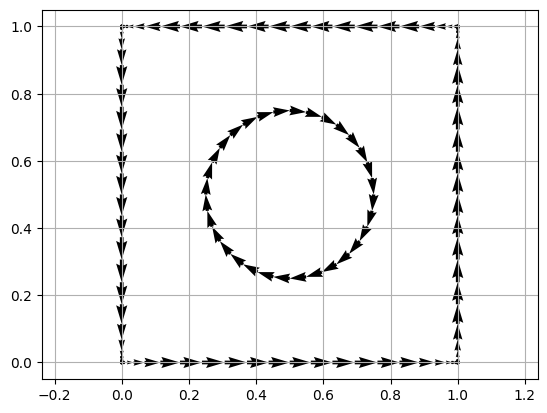

cell object
id: num_edges: 		5
num_holes: 		1
num_pts: 		160
contours: 		[[0, 1, 2, 3], [4]]
hole_int_pts (x): 	[0.5]
hole_int_pts (y): 	[0.5]



In [55]:
import puncturedfem as pf
import numpy as np

# define quadrature schemes
n = 16
q_trap = pf.quad.quad.quad(qtype='trap', n=n)
q_kress = pf.quad.quad.quad(qtype='kress', n=n)

# initialize list of edges as empty list
edge_list = []

# bottom: (0,0) to (1,0)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,0], [1,0])
edge_list.append(e)

# right: (1,0) to (1,1)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,0], [1,1])
edge_list.append(e)

# top: (1,1) to (0,1)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,1], [0,1])
edge_list.append(e)

# left: (0,1) to (0,0)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,1], [0,0])
edge_list.append(e)

# inner circular boundary
e = pf.mesh.edge.edge(etype='circle', q=q_trap)
e.reverse_orientation()
e.dialate(0.25)
e.translate([0.5, 0.5])
edge_list.append(e)

# check orientation
pf.plot.edges.edges(edge_list, orientation=True)

# define mesh cell
K = pf.mesh.cell.cell(edge_list=edge_list)
print(K)

## Define a Local Function

A local function $v \in V_p(K)$ can be uniquely defined by specifying its 
Dirichlet trace $v|_{\partial K}$ and Laplacian $\Delta v$.
In practice, $v$ would be implicitly defined in this way, but for the purpose 
of testing our numerics, we will consider explicitly defined functions for this
example.

### Define a Dirichlet Trace

Consider the function $v$ given by 
\begin{align*}
	v(x) = e^{x_1} \, \cos x_2 + a \ln|x-\xi| + x_1^3 x_2 + x_1 x_2^3
	~,
\end{align*}
where $a = 1$ and $\xi = (0.5, 0.5)$ is a point located in the hole of $K$.
We see immediately that $v$ can be decomposed into a harmonic part $\phi$ and
a polynomial part $P$:
\begin{align*}
	v &= \phi + P~,
	\\ 
	\phi(x) &= e^{x_1} \, \cos x_2 + a \ln|x-\xi|~,
	\\
	P(x) &= x_1^3 x_2 + x_1 x_2^3
	~. 
\end{align*}
First, let's compute the values of the Dirichlet trace of $v$:

In [56]:
# set target value of logarithmic coefficient
a_exact = 1

# set point in hole interior
xi = [0.5, 0.5]

# get the coordinates of sampled boundary points
x1, x2 = K.get_boundary_points()

# define trace of v
v_trace = np.exp(x1) * np.cos(x2) + \
    0.5 * a_exact * np.log((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2) + \
    x1 ** 3 * x2 + x1 * x2 ** 3

### Define a Polynomial Laplacian

The Laplacian of $v$ is given by 
\begin{align*}
	\Delta v(x) = \Delta P(x) = 12 x_1 x_2~.
\end{align*}
We will encode this an a `polynomial` object with a multi-index 
$\alpha = (0,1)$ and coefficient $c_\alpha = 2$.

In [57]:
# initalize polynomial object (defaults to zero polynomial)
v_laplacian = pf.poly.poly.polynomial()

# define a monomial term by specifying its multi-index and coefficient
alpha = pf.poly.multi_index.multi_index_2(alpha=[1, 1])
c_alpha = 12.0
m = pf.poly.monomial.monomial(alpha=alpha, coef=c_alpha)

# add monomial to polynomial
v_laplacian.add_monomial(m)

### Define a Local Function

We are now ready to define $v$ as a `locfun` object:

In [58]:
v = pf.locfun.locfun.locfun(v_trace, v_laplacian)

To proceed with our calculations, we must determine a polynomial anti-Laplacian
of $\Delta v$, which we might expect to be $P(x) = x_1^3 x_2 + x_1 x_2^3$.

In [59]:
v.compute_polynomial_part()
print(v.get_polynomial_part())

+ (1.0) x^3 y + (1.0) x y^3 


**Remark.** The decomposition $v = \phi + P$ is not unique, since the 
intersection between harmonic functions and polynomials is contains more than
just the zero function (a lot more).
The polynomial $P(x) = x_1^3 x_2 + x_1 x_2^3$ was chosen carefully for this example
so that the computed anti-Laplacian of $\Delta P(x) = 12 x_1 x_2$ coincides 
with $P$.
This will not generally be the case.

## Find the Normal Derivative

Our first task is to compute the normal derivative of $v = \phi + P$.
Recall that a *harmonic conjugate* of a harmonic function 
$\psi$ is another harmonic function,
which we will denote by $\widehat\psi$, for which the Cauchy-Riemann equations
are satisfied:
\begin{align*}
	\frac{\partial\phi}{\partial x_1} 
	= \frac{\partial\widehat\phi}{\partial x_2}
	~,\quad
	\frac{\partial\phi}{\partial x_2} 
	= -\frac{\partial\widehat\phi}{\partial x_1}
	~.
\end{align*}
It follows that the normal derivative of $\psi$ and the tangential derivative
of $\widehat\psi$ are equal:
\begin{align*}
	\frac{\partial\psi}{\partial\mathbf{n}} 
	= \frac{\partial\widehat\psi}{\partial\mathbf{t}}
	~.
\end{align*}
There is a minor issue when dealing with domains with holes:
$\widehat\psi$ may not exist. Fortunately, we have a workaround.

**Logarithmic Conjugation Theorem.**
Given a harmonic function $\phi$ and points $\xi_j$ 
located in the interior of the $j$-th hole ($1\leq j\leq m$), 
then there is a harmonic function $\psi$ with a harmonic 
conjugate and real coefficients $a_1,\dots,a_m$ such that 
\begin{align*}
	\phi(x) = \psi(x) + \sum_{j=1}^m a_m \ln|x-\xi_j|
	~.
\end{align*}
We will determine the trace of $\widehat\psi$ and the logarithmic 
coefficients $a_1, \dots, a_m$ by solving an integral equation numerically.
The user does not need to know the specifics, but merely needs to call
the following two methods.

In [60]:
v.compute_polynomial_part_trace(K)
v.compute_harmonic_conjugate(K)

### Error in Logarithmic Coefficient

Recall that 
\begin{align*}
	\phi(x) = \psi(x) + a \ln|x-\xi|~,
	\quad 
	\psi(x) = e^{x_1} \, \cos x_2~,
\end{align*}
with $\widehat\psi(x) = e^{x_1} \, \sin(x_2)$ being a harmonic conjugate of 
$\psi$.
We chose the point $\xi = (0.5, 0.5)$ carefully for this problem,
since this is also the interior point $\xi_1$ that was chosen automatically
when we created $K$.
Therefore, we ought to find that $a_1 = a = 1$, which we can check now:

In [61]:
print('Computed logarithmic coefficient = ', v.log_coef[0])
print('Error = ', abs(v.log_coef[0] - a_exact))

Computed logarithmic coefficient =  0.9999999989972596
Error =  1.0027404462320533e-09


### Error in Harmonic Conjugate Trace  

Recall that 
$$
	\widehat\psi(x) = e^{x_1} \, \sin x_2
$$
is a harmonic conjugate of $\psi(x) = e^{x_1} \, \cos x_2$.
Let's compare this to the computed trace of $\widehat\psi$.
We can use call `plot.traceplot.trace()` to plot the trace(s) 
of function(s) on the boundary.

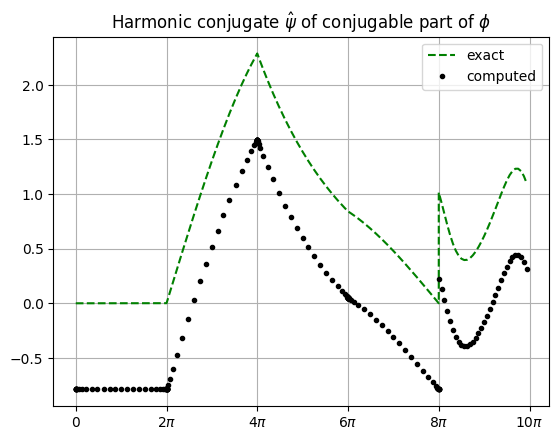

In [62]:
# get computed value of psi_hat
psi_hat_computed = v.get_harmonic_conjugate()

# get exact trace of psi_hat
psi_hat_exact = np.exp(x1) * np.sin(x2)

# plot harmonic conjugate
quad_list = [q_trap, q_kress,]
f_trace_list = [psi_hat_exact, psi_hat_computed,]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Harmonic conjugate $\hat\psi$ of conjugable part of $\phi$'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

**Note**: A harmonic conjugate is unique only up to an additive constant.
So to compute the error in $\hat\psi$,
we compute $\hat\psi_\text{exact} - (\widehat\psi_\text{computed} - c)$, 
where $c$ is a constant that minimizes the $L^2(\partial K)$ norm,
which is
\begin{align*}
	c = -\frac{1}{|\partial K|}\int_{\partial K} 
	(\hat\psi_\text{exact} - \widehat\psi_\text{computed}) ~ds
	~.
\end{align*}

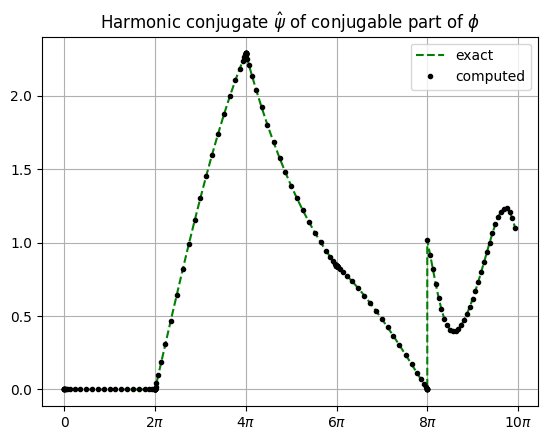

In [63]:
# average square distance between values
boundary_length = K.integrate_over_boundary(np.ones((K.num_pts,)))
integrated_difference = \
    K.integrate_over_boundary(psi_hat_exact - psi_hat_computed)
c = - integrated_difference / boundary_length

# plot harmonic conjugate
quad_list = [q_trap, q_kress,]
f_trace_list = [psi_hat_exact, psi_hat_computed - c ,]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Harmonic conjugate $\hat\psi$ of conjugable part of $\phi$'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

Compute and plot the error in the computed harmonic conjugate.

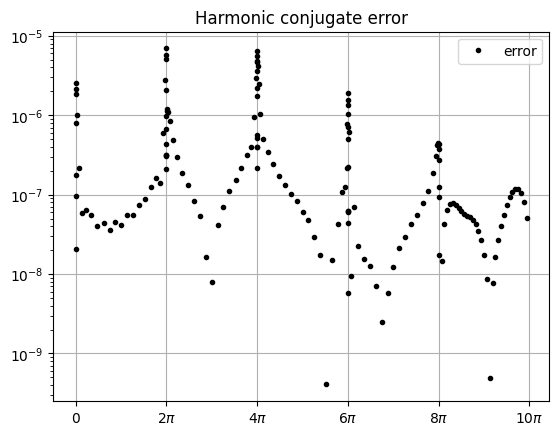

In [64]:
# compute errors in harmonic conjugate
psi_hat_error = np.abs(psi_hat_exact - psi_hat_computed + c)

# plot harmonic conjugate error
f_trace_list = [psi_hat_error,]
fmt = ('k.',)
legend = ('error',)
title = 'Harmonic conjugate error'
pf.plot.traceplot.trace_log(f_trace_list, fmt, legend, title, K, quad_list)

The pointwise errors look alright. 
Let's compute the $L^2(\partial K)$ norm of the error:

In [65]:
max_hc_error = max(psi_hat_error)
l2_hc_error = np.sqrt(K.integrate_over_boundary(psi_hat_error ** 2))
print('Max pointwise error = %.4e'%max_hc_error)
print('L^2 norm of error = %.4e'%l2_hc_error)

Max pointwise error = 6.9285e-06
L^2 norm of error = 1.1884e-06


### Compute the Normal Derivative

Recall that the Cauchy-Riemann equations imply that we can obtain the normal 
derivative of $\psi$ using the tangential derivative of its harmonic conjugate:
$$
	\dfrac{\partial\psi}{\partial\mathbf{n}} 
	= \dfrac{\partial\hat\psi}{\partial\mathbf{t}}
	~.
$$
Furthermore, if $x(t)$ is a parameterization of $\partial K$, we have 
$$
	\dfrac{d}{dt}\hat\psi(x(t)) 
	= \dfrac{\partial\hat\psi(x(t))}{\partial\mathbf{t}} \, |x'(t)|
	~.
$$
We refer to this derivative as a **weighted tangential derivative**.
Similarly, we refer to 
\begin{align*}
	\dfrac{\partial\psi(x(t))}{\partial\mathbf{n}} \, |x'(t)|
\end{align*}
the a **weighted tangential derivative** of $\psi$.

**Remark.** Fortunately for us, $|x'(t)|$ appears as the Jacobian in the 
integral
\begin{align*}
	\int_{\partial K} \eta \, \frac{\partial\psi}{\partial\mathbf{n}}~ds
	=
	\int_a^b \eta(x(t)) \, 
	\dfrac{\partial\psi(x(t))}{\partial\mathbf{n}} \, |x'(t)| ~dt
	~,
\end{align*}
so we will be satisfied with the weighted normal derivative.

**Remark.** 
If $\partial K$ is parameterized with a regular curve 
(i.e. $|x'(t)| > 0$ for all $t$),
then we can recover the normal derivative values. 
However, this is not recommended when $K$ has corners, 
as the reparameterization using Kress sampling is not regular, 
leading to division-by-zero headaches.
This is reflected in the fact that normal derivatives of harmonic functions
are discontinuous when $\partial K$ has corners, and indeed the normal 
derivative may even be unbounded.

Let's obtain the weighted normal derivative of $\phi$ by calling the 
`compute_harmonic_weighted_normal_derivative()` method.

In [66]:
# compute weighted normal derivative
v.compute_harmonic_weighted_normal_derivative(K)

Note that the exact values of the normal derivative are given by
\begin{align*}
	\frac{\partial\phi}{\partial\mathbf{n}} =
	\nabla\phi(x) \cdot \mathbf{n} = e^{x_1}
	\begin{pmatrix}
		\cos x_2 \\ -\sin x_2
	\end{pmatrix}
	\cdot \mathbf{n}
	+
	a \, \frac{(x-\xi) \cdot \mathbf{n}}{|x - \xi|^2}
\end{align*}
Let's compute these exact values for comparison.

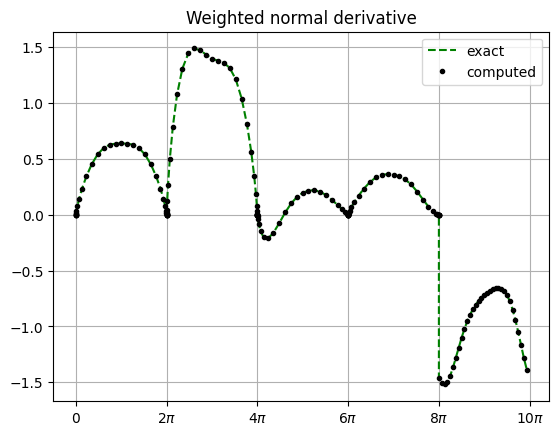

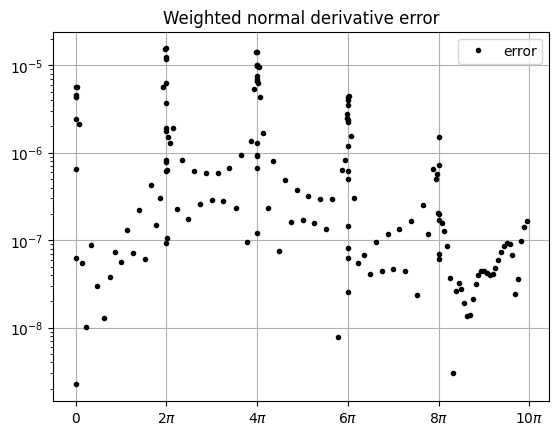

In [67]:
# define the components of the gradient of phi
phi_x1 = np.exp(x1) * np.cos(x2) + \
    a_exact * (x1 - xi[0]) / ((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2)
phi_x2 = -np.exp(x1) * np.sin(x2) + \
    a_exact * (x2 - xi[1]) / ((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2)

# compute exact weighted normal derivative
phi_nd = K.dot_with_normal(phi_x1, phi_x2)
phi_wnd_exact = K.multiply_by_dx_norm(phi_nd)

# get computed values
phi_wnd_computed = v.get_harmonic_weighted_normal_derivative()

# compute errors
wnd_error = np.abs(phi_wnd_computed - phi_wnd_exact)

# plot exact and computed weighted normal derivatives
quad_list = [q_trap, q_kress,]
f_trace_list = [phi_wnd_exact, phi_wnd_computed,]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Weighted normal derivative'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

# plot errors
f_trace_list = [wnd_error,]
fmt = ('k.',)
legend = ('error',)
title = 'Weighted normal derivative error'
pf.plot.traceplot.trace_log(f_trace_list, fmt, legend, title, K, quad_list)

Let's look at the maximum pointwise error as well as the error in the
$L^2(\partial K)$ norm:

In [68]:
# compute and print errors
max_wnd_error = max(wnd_error)
l2_wnd_error = np.sqrt(K.integrate_over_boundary(wnd_error ** 2))
print('Max pointwise error = %.4e'%max_wnd_error)
print('L^2 norm of wnd error = %.4e'%l2_wnd_error)

Max pointwise error = 1.5605e-05
L^2 norm of wnd error = 3.7415e-06


### Find an Anti-Laplacian

Our second task is to find an anti-Laplacian $\Phi$ such that $\Delta\Phi=\phi$.
Note that
\begin{align*}
	\Lambda(x) = \frac14 |x|^2 \big(\ln|x|-1 \big)
\end{align*}
is an anti-Laplacian of $\lambda(x) = \ln|x|$.
So if $\Psi$ is an anti-Laplacian of $\psi$, then we would have
\begin{align*}
	\Phi(x) = \Psi(x) + \sum_{k=1}^m a_k \Lambda(x-\xi_k)
\end{align*}
is an anti-Laplacian of 
\begin{align*}
	\phi(x) = \psi(x) + \sum_{k=1}^m a_k \ln|x-\xi_k|
	~.
\end{align*}
All of this handled internally when we call the 
`compute_anti_laplacian_harmonic_part()` method.

In [69]:
v.compute_anti_laplacian_harmonic_part(K)

Let's compare the computed values of $\Phi$ to 
\begin{align*}
	\tilde\Phi(x) = \frac14 e^{x_1}
	\big(x_1 \cos x_2 + x_2 \sin x_2\big)
	+ \frac14 |x - \xi|^2 \big(\ln|x - \xi|-1 \big)
	~,
\end{align*}
which is an anti-Laplacian of $\phi$.

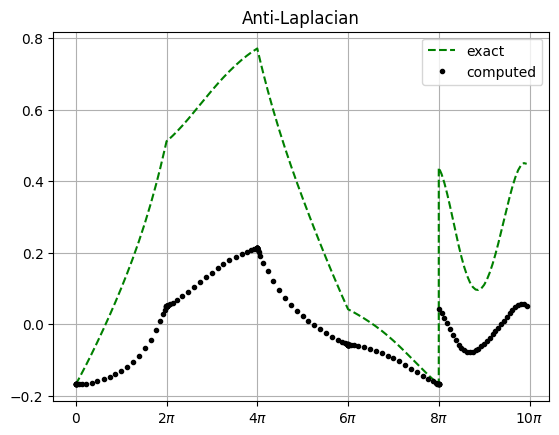

In [70]:
# an exact anti-Laplacian
PHI_exact = 0.25 * np.exp(x1) * (x1 * np.cos(x2) + x2 * np.sin(x2)) + \
	0.25 * ((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2) * ( \
    0.5 * np.log((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2) - 1)

# computed anti-Laplacian
PHI_computed = v.get_anti_laplacian_harmonic_part()

quad_list = [q_trap, q_kress,]
f_trace_list = [PHI_exact, PHI_computed]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Anti-Laplacian'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

In general, $\Phi$ is unique only up to the addition of a harmonic function.
Indeed, if $\Phi$ and $\widetilde\Phi$ are both anti-Laplacians of $\phi$, 
we have 
\begin{align*}
	\Delta (\Phi - \widetilde\Phi) = \phi - \phi = 0
	~.
\end{align*}
However, in this case we can say more. 
As a consequence of the way that $\Phi$ and $\widetilde\Phi$ were computed, 
it ought to hold that
\begin{align*}
	\Psi - \widetilde\Psi = c \cdot x
\end{align*}
is a linear function.
We will test this conjecture by performing a least squares best linear fit 
on the computed values of $\Psi - \widetilde\Psi$.

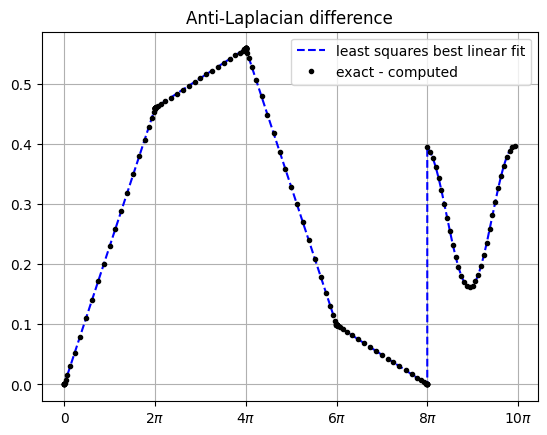

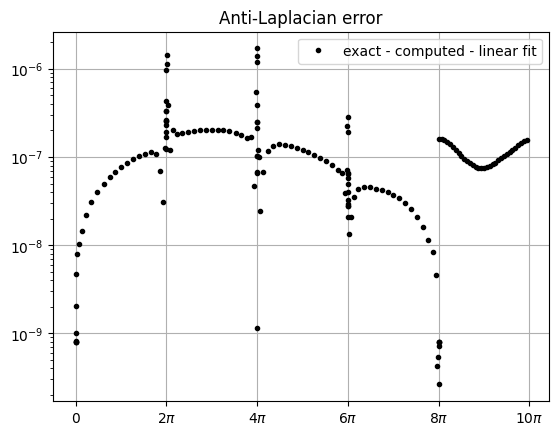

In [71]:
PHI_diff = PHI_exact - PHI_computed

X = np.zeros((K.num_pts, 2))
X[:,0] = x1
X[:,1] = x2
XX = np.transpose(X) @ X
Xy = np.transpose(X) @ PHI_diff
aa = np.linalg.solve(XX, Xy)
PHI_diff_fit = X @ aa

PHI_diff_error = np.abs(PHI_diff_fit - PHI_diff)

quad_list = [q_trap, q_kress,]
f_trace_list = [PHI_diff_fit, PHI_diff]
fmt = ('b--','k.')
legend = ('least squares best linear fit', 'exact - computed')
title = 'Anti-Laplacian difference'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

quad_list = [q_trap, q_kress,]
f_trace_list = [PHI_diff_error,]
fmt = ('k.',)
legend = ('exact - computed - linear fit',)
title = 'Anti-Laplacian error'
pf.plot.traceplot.trace_log(f_trace_list, fmt, legend, title, K, quad_list)

As before, let's compute the maximum pointwise error and the 
$L^2(\partial K)$ error.

In [72]:
max_PHI_error = max(PHI_diff_error)
l2_PHI_error = np.sqrt(K.integrate_over_boundary(PHI_diff_error ** 2))
print('Max pointwise error = %.4e'%max_PHI_error)
print('L^2 norm of error = %.4e'%l2_PHI_error)

Max pointwise error = 1.7010e-06
L^2 norm of error = 3.3785e-07


Before we use $v$ for computations, we need to compute the trace and 
weighted normal derivative of $P$, the polynomial part of $v = \phi + P$.

In [73]:
v.compute_polynomial_part_trace(K)
v.compute_polynomial_part_weighted_normal_derivative(K)

## Define another function

Let $w : K \to \mathbb{R}$ is given by 
\begin{align*}
	w(x) = \frac{x_1 - 0.5}{(x_1 - 0.5)^2 + (y - 0.5)^2} + x_1^3 + x_1 x_2^2
	~.
\end{align*}
Again, we have that $w = \psi + Q$ is the sum of a harmonic function and 
a polynomial, with
\begin{align*}
	\psi(x) = \frac{x_1 - 0.5}{(x_1 - 0.5)^2 + (y - 0.5)^2} 
	~,
	\quad
	Q(x) = x_1^3 + x_1 x_2^2
	~.
\end{align*}
(The notation "$\psi$" is being recycled here.)

In [74]:
# trace of w
w_trace = (x1 - 0.5) / ((x1 - 0.5) ** 2 + (x2 - 0.5) ** 2) + \
    x1 ** 3 + x1 * x2 ** 2

# initalize polynomial object (defaults to zero polynomial)
w_laplacian = pf.poly.poly.polynomial()

# define a monomial term by specifying its multi-index and coefficient
alpha = pf.poly.multi_index.multi_index_2(alpha=[1, 0])
c_alpha = 8.0
m = pf.poly.monomial.monomial(alpha=alpha, coef=c_alpha)

# add monomial to polynomial
w_laplacian.add_monomial(m)

# declare w as local function object
w = pf.locfun.locfun.locfun(w_trace, w_laplacian)

For convenience, we don't need to call all of the `compute` methods we did for
$v$. Instead, we call `compute_all()`.

In [75]:
w.compute_all(K)

## $H^1$ semi-inner product

We are now ready to compute the $H^1$ semi-inner product between $v$ and $w$.
This can be done by calling the `compute_h1()` method from either function.

In [76]:
h1_vw_computed = v.compute_h1(w, K)
print('H^1 semi-inner product (vw) = ',h1_vw_computed)

H^1 semi-inner product (vw) =  4.46481695459581


In exact arithmetic, the $H^1$ semi-inner product is symmetric.
Let's check that we get the same thing if we compute in the opposite order.

In [77]:
h1_wv_computed = w.compute_h1(v, K)
print('H^1 semi-inner product (wv) = ', h1_wv_computed)

H^1 semi-inner product (wv) =  4.464816311413625


Here's the difference between the two:

In [78]:
print('Difference in computed H^1 = ', abs(h1_vw_computed - h1_wv_computed))

Difference in computed H^1 =  6.431821857333375e-07


Finally, let's compare this to the value obtained with *Mathematica*:
\begin{align*}
	\int_K \nabla v \cdot \nabla w ~ dx
	&\approx 4.46481780319135
	\pm 9.9241 \times 10^{-15}
\end{align*}
where the value after "$\pm$" indicates the estimated error in this value
according to *Mathematica*.

In [79]:
h1_vw_exact = 4.46481780319135
4.46481780319135
print('H^1 error (vw) = ', abs(h1_vw_computed - h1_vw_exact))
print('H^1 error (wv) = ', abs(h1_wv_computed - h1_vw_exact))

H^1 error (vw) =  8.485955396153599e-07
H^1 error (wv) =  1.4917777253486975e-06


## $L^2$ Inner Product

Let's compute the $L^2$ inner product
\begin{align*}
	\int_K v \, w ~dx
	&\approx 1.39484950156676
	\pm 2.7256 \times 10^{-16}
\end{align*}
whose approximate value was obtained with *Mathematica*.

In [80]:
l2_vw_computed = v.compute_l2(w, K)
print('L^2 inner product (vw) = ',l2_vw_computed)
l2_wv_computed = w.compute_l2(v, K)
print('L^2 inner product (wv) = ', l2_wv_computed)
print('Difference in computed L^2 = ', abs(l2_vw_computed - l2_wv_computed))
l2_vw_exact = 1.39484950156676
print('L^2 error (vw) = ', abs(l2_vw_computed - l2_vw_exact))
print('L^2 error (wv) = ', abs(l2_wv_computed - l2_vw_exact))

L^2 inner product (vw) =  1.394849540559463
L^2 inner product (wv) =  1.3948495410581407
Difference in computed L^2 =  4.986777657478569e-10
L^2 error (vw) =  3.899270306639835e-08
L^2 error (wv) =  3.9491380832146206e-08


## Convergence Studies

We repeated the above experiment for several values of the quadrature parameter
$n$ (where each edge of $\partial K$ is sampled at $2n$ points).

Here's what we found for the intermediate computations on $v$:

|	n	|	a_1 error	|	hc error	|	wnd error	|	al error	|	H1 error	|	L2 error	|
|-------|---------------|---------------|---------------|---------------|---------------|---------------|
|	4	|	1.7045e-03	|	3.5785e-02	|	2.8201e-01	|	8.3234e-03	|	1.5180e-02	|	3.4040e-03	|
|	8	|	3.5531e-07	|	2.6597e-04	|	1.2855e-03	|	3.9429e-05	|	2.6758e-04	|	8.3812e-05	|
|	16	|	1.0027e-09	|	1.1884e-06	|	3.7415e-06	|	3.3785e-07	| 	8.4860e-07	|	3.8993e-08	|
|	32	|	3.5905e-13	|	2.3095e-09	|	1.0434e-08	|	1.9430e-09	|	1.0860e-09	|	2.8398e-11	|
|	64	|	1.8874e-14	|	1.6313e-12	|	6.4780e-11	|	7.0728e-12	|	9.5390e-13	|	1.1036e-13	|

In [81]:
print(q_kress.n)

print('')

print('log coef error = %.4e'%abs(v.log_coef[0] - a_exact))
print('L^2 norm of hc error = %.4e'%l2_hc_error)
print('L^2 norm of wnd error = %.4e'%l2_wnd_error)
print('L^2 norm of antilap error = %.4e'%l2_PHI_error)

print('')

print('H^1 error (vw) = %.4e'%abs(h1_vw_computed - h1_vw_exact))
print('L^2 error (vw) = %.4e'%abs(l2_vw_computed - l2_vw_exact))

16

log coef error = 1.0027e-09
L^2 norm of hc error = 1.1884e-06
L^2 norm of wnd error = 3.7415e-06
L^2 norm of antilap error = 3.3785e-07

H^1 error (vw) = 8.4860e-07
L^2 error (vw) = 3.8993e-08
